In [4]:
# ============================================================
# PyTorch + Optuna: Binary classification optimizing accuracy
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import optuna

# ------------------------------------------------------------
# 1. (Example) Generate or load your dataset
# ------------------------------------------------------------
# Replace this with your actual dataset
n = 18

X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

# First split: train 60%, temp 40%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
# Second split: val 20%, test 20%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ------------------------------------------------------------
# 2. Preprocessing
# ------------------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# ------------------------------------------------------------
# 3. Define flexible MLP model
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate, activation_fn):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hdim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hdim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hdim
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))


# ------------------------------------------------------------
# 4. Training + Validation function
# ------------------------------------------------------------
def train_and_evaluate(model, optimizer, criterion,
                       X_train, y_train, X_val, y_val,
                       epochs=50, batch_size=64):
    n = len(X_train)
    for epoch in range(epochs):
        model.train()
        idx = torch.randperm(n)
        X_train, y_train = X_train[idx], y_train[idx]
        
        for i in range(0, n, batch_size):
            xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        preds_val = model(X_val)
    preds_bin = (preds_val > 0.5).float()
    acc = accuracy_score(y_val, preds_bin)
    return acc


# ------------------------------------------------------------
# 5. Optuna Objective Function (optimize validation accuracy)
# ------------------------------------------------------------
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512, 768, 1024])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    activation_name = trial.suggest_categorical("activation", ["ReLU", "Tanh", "GELU"])
    
    activation_fn = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "GELU": nn.GELU}[activation_name]
    hidden_dims = [hidden_dim] * n_layers
    
    model = MLP(input_dim=X_train.shape[1],
                hidden_dims=hidden_dims,
                dropout_rate=dropout_rate,
                activation_fn=activation_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    acc = train_and_evaluate(model, optimizer, criterion, X_train, y_train, X_val, y_val)
    return acc


# ------------------------------------------------------------
# 6. Run Optuna optimization
# ------------------------------------------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_trial = study.best_trial
print("\nBest Validation Results")
print("------------------------")
print(f"Validation Accuracy: {best_trial.value:.4f}")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")


# ------------------------------------------------------------
# 7. Evaluate on Test Set using Best Params
# ------------------------------------------------------------
def train_full_and_test(params):
    n_layers = params["n_layers"]
    hidden_dim = params["hidden_dim"]
    dropout_rate = params["dropout_rate"]
    lr = params["lr"]
    weight_decay = params["weight_decay"]
    activation_fn = {"ReLU": nn.ReLU, "Tanh": nn.Tanh, "GELU": nn.GELU}[params["activation"]]
    
    model = MLP(input_dim=X_train.shape[1],
                hidden_dims=[hidden_dim] * n_layers,
                dropout_rate=dropout_rate,
                activation_fn=activation_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Train on train + val (80%) for better generalization
    X_combined = torch.cat([X_train, X_val], dim=0)
    y_combined = torch.cat([y_train, y_val], dim=0)
    
    _ = train_and_evaluate(model, optimizer, criterion, X_combined, y_combined, X_test, y_test)
    
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test)
    preds_bin = (preds_test > 0.5).float()
    test_acc = accuracy_score(y_test, preds_bin)
    return test_acc

test_acc = train_full_and_test(best_trial.params)
print("\nFinal Test Accuracy (using best params): {:.4f}".format(test_acc))

[I 2025-10-30 15:16:22,222] A new study created in memory with name: no-name-09f68f65-afb4-4f14-8db1-a7a5de362b7f


Train: 21600, Val: 7200, Test: 7200


[I 2025-10-30 15:17:01,262] Trial 0 finished with value: 0.49291666666666667 and parameters: {'n_layers': 5, 'hidden_dim': 256, 'dropout_rate': 0.3877662334998227, 'lr': 0.00010859255618506749, 'weight_decay': 2.1418007198836864e-05, 'activation': 'GELU'}. Best is trial 0 with value: 0.49291666666666667.
[I 2025-10-30 15:17:05,230] Trial 1 finished with value: 0.5009722222222223 and parameters: {'n_layers': 1, 'hidden_dim': 128, 'dropout_rate': 0.4913170662116411, 'lr': 0.0005004804546734269, 'weight_decay': 5.295449680471081e-06, 'activation': 'ReLU'}. Best is trial 1 with value: 0.5009722222222223.
[I 2025-10-30 15:17:17,225] Trial 2 finished with value: 0.49833333333333335 and parameters: {'n_layers': 3, 'hidden_dim': 128, 'dropout_rate': 0.10877255873255409, 'lr': 0.0001259121869267624, 'weight_decay': 3.0438103667779025e-05, 'activation': 'GELU'}. Best is trial 1 with value: 0.5009722222222223.
[I 2025-10-30 15:17:38,480] Trial 3 finished with value: 0.9718055555555556 and paramet


Best Validation Results
------------------------
Validation Accuracy: 0.9718
  n_layers: 2
  hidden_dim: 512
  dropout_rate: 0.31779700399889654
  lr: 0.00353767015550948
  weight_decay: 3.3808863091951804e-06
  activation: Tanh

Final Test Accuracy (using best params): 0.9661


### For n = 10
Validation Accuracy: 0.9627

  n_layers: 1
  hidden_dim: 256
  dropout_rate: 0.4027371651972238
  lr: 0.008265555263166885
  weight_decay: 9.054101276144208e-06
  activation: ReLU

Final Test Accuracy (using best params): 0.9615


### For n = 12
Validation Accuracy: 0.9606
  n_layers: 2
  hidden_dim: 256
  dropout_rate: 0.29257082699124565
  lr: 0.001426579019898136
  weight_decay: 3.7383700968473337e-06
  activation: Tanh

Final Test Accuracy (using best params): 0.9421

### For n = 14
Validation Accuracy: 0.9646

  n_layers: 2
  hidden_dim: 256
  dropout_rate: 0.18930988641398677
  lr: 0.0005284962214684265
  weight_decay: 1.8689152926603513e-05
  activation: ReLU

Final Test Accuracy (using best params): 0.9634

### For n = 16
Validation Accuracy: 0.9619

  n_layers: 3
  hidden_dim: 512
  dropout_rate: 0.22305400020665447
  lr: 0.0003932872869573933
  weight_decay: 5.556403819066895e-06
  activation: Tanh

Final Test Accuracy (using best params): 0.9470

### For n = 18
Validation Accuracy: 0.9718

  n_layers: 2
  hidden_dim: 512
  dropout_rate: 0.31779700399889654
  lr: 0.00353767015550948
  weight_decay: 3.3808863091951804e-06
  activation: Tanh

Final Test Accuracy (using best params): 0.9661

### For n = 20
Validation Accuracy: 0.9493

  n_layers: 3
  hidden_dim: 1024
  dropout_rate: 0.042366486743149634
  lr: 0.0007384888819631559
  weight_decay: 6.772946771940114e-06
  activation: Tanh

Final Test Accuracy (using best params): 0.9621


In [6]:
# ============================================================
# Train optimal neural nets for n = 10, 12, 14, 16, 18, 20
# 80/20 train-test split, report test accuracy
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ------------------------------------------------------------
# 1. Define the MLP architecture
# ------------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, n_layers, hidden_dim, dropout_rate, activation_fn):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))

# ------------------------------------------------------------
# 2. Training function
# ------------------------------------------------------------
def train_and_test(X, y, params):
    # Train-test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Scale data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # Model setup
    activation_map = {"ReLU": nn.ReLU, "Tanh": nn.Tanh}
    model = MLP(
        input_dim=X.shape[1],
        n_layers=params["n_layers"],
        hidden_dim=params["hidden_dim"],
        dropout_rate=params["dropout_rate"],
        activation_fn=activation_map[params["activation"]],
    )

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])

    # Train loop
    epochs = 50
    batch_size = 64
    n = len(X_train)
    for epoch in range(epochs):
        model.train()
        idx = torch.randperm(n)
        X_train, y_train = X_train[idx], y_train[idx]
        for i in range(0, n, batch_size):
            xb = X_train[i:i+batch_size]
            yb = y_train[i:i+batch_size]
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test)
    preds_bin = (preds_test > 0.5).float()
    acc = accuracy_score(y_test, preds_bin)
    return acc

# ------------------------------------------------------------
# 3. Given optimal hyperparameters
# ------------------------------------------------------------
param_dict = {
    10: {"n_layers": 1, "hidden_dim": 256, "dropout_rate": 0.4027371651972238, "lr": 0.008265555263166885,
         "weight_decay": 9.054101276144208e-06, "activation": "ReLU"},
    12: {"n_layers": 2, "hidden_dim": 256, "dropout_rate": 0.29257082699124565, "lr": 0.001426579019898136,
         "weight_decay": 3.7383700968473337e-06, "activation": "Tanh"},
    14: {"n_layers": 2, "hidden_dim": 256, "dropout_rate": 0.18930988641398677, "lr": 0.0005284962214684265,
         "weight_decay": 1.8689152926603513e-05, "activation": "ReLU"},
    16: {"n_layers": 3, "hidden_dim": 512, "dropout_rate": 0.22305400020665447, "lr": 0.0003932872869573933,
         "weight_decay": 5.556403819066895e-06, "activation": "Tanh"},
    18: {"n_layers": 2, "hidden_dim": 512, "dropout_rate": 0.31779700399889654, "lr": 0.00353767015550948,
         "weight_decay": 3.3808863091951804e-06, "activation": "Tanh"},
    20: {"n_layers": 3, "hidden_dim": 1024, "dropout_rate": 0.042366486743149634, "lr": 0.0007384888819631559,
         "weight_decay": 6.772946771940114e-06, "activation": "Tanh"}
}

# ------------------------------------------------------------
# 4. Run all models and report test accuracy
# ------------------------------------------------------------
results = {}

for n, params in param_dict.items():
    print(f"\nTraining model for n = {n} ...")
    X = np.load('Datasets/kryptonite-%s-X.npy'%(n))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(n))

    acc = train_and_test(X, y, params)
    results[n] = acc
    print(f"Test Accuracy (n={n}): {acc:.4f}")

# ------------------------------------------------------------
# 5. Summary
# ------------------------------------------------------------
print("\n========== Summary of Test Accuracies ==========")
for n, acc in results.items():
    print(f"n = {n:2d} → Test Accuracy: {acc:.4f}")



Training model for n = 10 ...
Test Accuracy (n=10): 0.9625

Training model for n = 12 ...
Test Accuracy (n=12): 0.9587

Training model for n = 14 ...
Test Accuracy (n=14): 0.9634

Training model for n = 16 ...
Test Accuracy (n=16): 0.9644

Training model for n = 18 ...
Test Accuracy (n=18): 0.9665

Training model for n = 20 ...
Test Accuracy (n=20): 0.9577

========== Summary of Test Accuracies ==========
n = 10 → Test Accuracy: 0.9625
n = 12 → Test Accuracy: 0.9587
n = 14 → Test Accuracy: 0.9634
n = 16 → Test Accuracy: 0.9644
n = 18 → Test Accuracy: 0.9665
n = 20 → Test Accuracy: 0.9577


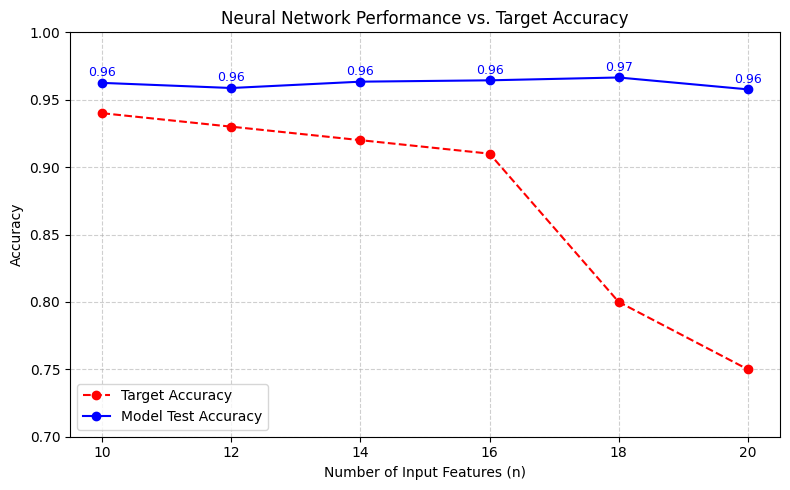

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Results from run
results = {10: 0.9625, 12: 0.9587, 14: 0.9634, 16: 0.9644, 18: 0.9665, 20: 0.9577}

# Target accuracies (provided)
target_acc = {
    10: 0.94,
    12: 0.93,
    14: 0.92,
    16: 0.91,
    18: 0.80,
    20: 0.75
}

# Sort both by n
n_values = sorted(results.keys())
test_acc_values = [results[n] for n in n_values]
target_acc_values = [target_acc[n] for n in n_values]

# Plot
plt.figure(figsize=(8,5))
plt.plot(n_values, target_acc_values, 'o--', label='Target Accuracy', color='red')
plt.plot(n_values, test_acc_values, 'o-', label='Model Test Accuracy', color='blue')

# Add annotations
for n, acc in zip(n_values, test_acc_values):
    plt.text(n, acc + 0.005, f"{acc:.2f}", ha='center', fontsize=9, color='blue')

# Styling
plt.title("Neural Network Performance vs. Target Accuracy")
plt.xlabel("Number of Input Features (n)")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
